In [1]:
import os
import tarfile
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from urllib.request import urlretrieve
from tqdm import tqdm

In [2]:
%matplotlib inline

#### Dataset info

CIFAR-10 is a dataset of 60 000 32x32 colour images, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. There are 10 different classes with 6000 images per class:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

Dataset is divided into 5 batches with the following naming convention 'data_batch_1', 'data_batch_2' and so on...

In [3]:
#: https://www.cs.toronto.edu/~kriz/cifar.html
DATA_URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
TARG_TZ_FILEPATH = "./cifar-10-python.tar.gz"
CIFAR10_FILES_FOLDER = './cifar-10-batches-py/'

TRAIN_BATCH_FILES = [
    "data_batch_1",
    "data_batch_2",
    "data_batch_3",
    "data_batch_4",
    "data_batch_5"
]

TEST_BATCH_FILE = "test_batch"

LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = 10

MAX_PIXEL_VALUE = 255
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
CHANNELS = 3

DATA_I = 0
LABELS_I = 1

#### Download dataset

In [4]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile(TARG_TZ_FILEPATH):
    with DLProgress(unit="B", unit_scale=True, miniters=1, desc="CIFAR-10") as pbar:
        urlretrieve(DATA_URL, TARG_TZ_FILEPATH, pbar.hook)

#### Exctracting data

- Unpacking

In [5]:
if not os.path.isdir(CIFAR10_FILES_FOLDER):
    with tarfile.open(TARG_TZ_FILEPATH) as tar:
        tar.extractall()
        tar.close()

- Loading train batches

In [6]:
train_batches = list()

for batch_file in TRAIN_BATCH_FILES: 
    with open(CIFAR10_FILES_FOLDER + batch_file, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
        # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
  
        train_batches.append((data, labels))

- Load test batch

In [7]:
test_batch = None

with open(CIFAR10_FILES_FOLDER + TEST_BATCH_FILE, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
         # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
        
        test_batch = (data, labels)

#### Present extracted dataset

In [8]:
def present_batch(batch, batch_index):
    features, labels = batch 
    print("Batch no." + str(batch_index))
    print("    - Samples in batch: " + str(len(features)))
    print("    - Labels num: " + str(dict(zip(*np.unique(labels, return_counts=True)))))
    
def present_sample(batch, sample_id):
    features, labels = batch 
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print("Sample no." + str(sample_id))
    print("    - Min Value: {} Max Value: {}".format(sample_image.min(), sample_image.max()))
    print("    - Shape: {}".format(sample_image.shape))
    print("    - Label - Label Id: {} Name: {}".format(sample_label, LABELS[sample_label]))
    
    plt.axis('off')
    plt.imshow(sample_image)

In [9]:
for index, batch in enumerate(train_batches):
    present_batch(batch, index)

Batch no.0
    - Samples in batch: 10000
    - Labels num: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
Batch no.1
    - Samples in batch: 10000
    - Labels num: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
Batch no.2
    - Samples in batch: 10000
    - Labels num: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
Batch no.3
    - Samples in batch: 10000
    - Labels num: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
Batch no.4
    - Samples in batch: 10000
    - Labels num: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}


Sample no.7164
    - Min Value: 26 Max Value: 246
    - Shape: (32, 32, 3)
    - Label - Label Id: 5 Name: dog


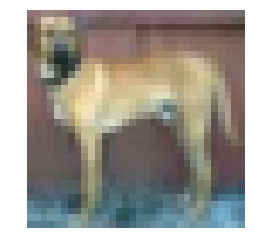

In [10]:
present_sample(train_batches[0], 7164)

#### Split data into train, val , test sets

- data is already shuffled

- concat all batches together

In [11]:
train_data = list()
train_labels = list()
for batch in train_batches:
    for data, label in zip(batch[DATA_I], batch[LABELS_I]):
        train_data.append(data)
        train_labels.append(label)
assert len(train_data) == len(train_labels)
        
test_data = list()
test_labels = list()
for data, label in zip(test_batch[DATA_I], test_batch[LABELS_I]):
    test_data.append(data)
    test_labels.append(label)
assert len(test_data) == len(test_labels)

- split data

In [12]:
split_ratio = 0.2
split_index = int(len(train_data) * split_ratio)

val_data = train_data[:split_index]
val_labels = train_labels[:split_index]

train_data = train_data[split_index:]
train_labels = train_labels[split_index:]

In [13]:
print("Train samples: " + str(len(train_data)))
print("Validation samples: " + str(len(val_data)))
print("Test samples: " + str(len(test_data)))

Train samples: 40000
Validation samples: 10000
Test samples: 10000


#### Preprocess data

In [14]:
def normalize(data):
    return data / MAX_PIXEL_VALUE

def ohe_label(label):
    labels_num = len(LABELS)
  
    encoding_array = np.zeros([labels_num])  
    encoding_array[label] = 1
        
    return encoding_array

In [15]:
train_data_norm = [normalize(data) for data in train_data]
train_labels_ohe = [ohe_label(label) for label in train_labels]

val_data_norm = [normalize(data) for data in val_data]
val_labels_ohe = [ohe_label(label) for label in val_labels]

test_data_norm = [normalize(data) for data in test_data]
test_labels_ohe = [ohe_label(label) for label in test_labels]

In [16]:
sample_to_inspect = 7124
sample = train_data_norm[sample_to_inspect]
label = train_labels_ohe[sample_to_inspect]
print("Sample no." + str(sample_to_inspect))
print("    - Min Value: {} Max Value: {}".format(sample.min(), sample.max()))
print("    - Label: " + str(label))

Sample no.7124
    - Min Value: 0.00784313725490196 Max Value: 0.9137254901960784
    - Label: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


#### Building ConvNet - parts

In [17]:
def conv_net_image_input(image_width, image_height, channels):
    return tf.placeholder(tf.float32, shape=[None, image_width, image_height, channels], name='inputs')

In [18]:
def conv_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='labels')

In [19]:
def conv_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")

In [20]:
def conv2d(tensor, layers, kernel_size, strides, activation,
           weights_init_mean=0.0, weights_init_stddev=0.1, padding="SAME"):
    
    weights_shape = (kernel_size[0], kernel_size[1], int(tensor.get_shape()[3]), layers)
    weights = tf.Variable(tf.truncated_normal(weights_shape, mean=weights_init_mean, stddev=weights_init_stddev))
    
    bias_shape = [layers]
    bias = tf.Variable(tf.truncated_normal(bias_shape, mean=weights_init_mean, stddev=weights_init_stddev))
    
    conv = tf.nn.conv2d(tensor, weights, strides=strides, padding=padding)
    conv_with_bias = tf.nn.bias_add(conv, bias)
    
    return activation(conv_with_bias)

In [21]:
def max_pool(tensor, kernel, strides, padding="SAME"):
    return tf.nn.max_pool(tensor, ksize=kernel, strides=strides, padding=padding)

In [22]:
def flatten(tensor):
    batch_size = tf.shape(tensor)[0] # value can be '?' 
    flattened_image_size = int(tensor.get_shape()[1]) * int(tensor.get_shape()[2]) * int(tensor.get_shape()[3])
    return tf.reshape(tensor, [batch_size, flattened_image_size])

In [23]:
def fully_conn(tensor, layer_size, activation, weights_init_mean=0.0, weights_init_stddev=0.1):
    weights_shape = (int(tensor.get_shape()[1]), layer_size)
    weights = tf.Variable(tf.truncated_normal(weights_shape, mean=weights_init_mean, stddev=weights_init_stddev)) 
    
    bias_shape = [layer_size]
    bias = tf.Variable(tf.truncated_normal(bias_shape, mean=weights_init_mean, stddev=weights_init_stddev))
    layer = tf.nn.bias_add(tf.matmul(tensor, weights), bias)    
    
    return activation(layer)

In [24]:
def output(tensor, layer_size, weights_init_mean=0.0, weights_init_stddev=0.1):
    weights_size = (int(tensor.get_shape()[1]), layer_size)
    weights = tf.Variable(tf.truncated_normal(weights_size, mean=weights_init_mean, stddev=weights_init_stddev)) 
    
    bias_shape = [layer_size]
    bias = tf.Variable(tf.truncated_normal(bias_shape, mean=weights_init_mean, stddev=weights_init_stddev))
    output_layer = tf.nn.bias_add(tf.matmul(tensor, weights), bias)    
    
    return output_layer

In [25]:
def conv_net(x, keep_prob):   
    kernel_size_3x3 = 3, 3
    kernel_size_2x2 = [1, 2, 2, 1]
    strides_1x1x1x1 = [1, 1, 1, 1]
    strides_1x2x2x1 = [1, 2, 2, 1]
    
    # conv layer + max pooling - 1
    conv1_layer = conv2d(x, 16, kernel_size_3x3, strides_1x1x1x1, tf.nn.relu)
    conv1_layer_mpool = max_pool(conv1_layer, kernel_size_2x2, strides_1x2x2x1)
    
    # conv layer + max pooling - 2
    conv2_layer = conv2d(conv1_layer_mpool, 32, kernel_size_3x3, strides_1x1x1x1, tf.nn.relu)
    conv2_layer_mpool = max_pool(conv1_layer, kernel_size_2x2, strides_1x2x2x1)
    
    # conv layer + max pooling - 3
    conv3_layer = conv2d(conv2_layer_mpool, 32, kernel_size_3x3, strides_1x1x1x1, tf.nn.relu)
    conv3_layer_mpool = max_pool(conv1_layer, kernel_size_2x2, strides_1x2x2x1)
    
    # fully connected layer - 1
    flatten_conv_output = flatten(conv3_layer_mpool)
    con1_layer = fully_conn(flatten_conv_output, 384, tf.nn.relu)
    con1_layer_dropout = tf.nn.dropout(con1_layer, keep_prob)

    return output(con1_layer_dropout, NUM_CLASSES)

#### Building ConvNet - assemble

- Reset Tensorflow graph

In [26]:
tf.reset_default_graph()

- Assemble model

In [27]:
inputs = conv_net_image_input(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
targets = conv_net_label_input(NUM_CLASSES)
keep_prob = conv_net_keep_prob_input()

model = conv_net(inputs, keep_prob)

- Cost function, training optimizer, correct predictions, accuracy

In [28]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=targets))
optimizer = tf.train.AdamOptimizer().minimize(cost)
correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#### Batch preparation

In [29]:
def prepare_mini_batches(data, labels, batch_size):
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    mini_batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return mini_batches

#### Hyperparameters

In [30]:
epochs = 45
batch_size = 256
keep_probability = 0.5

#### Training cycle

In [31]:
session = tf.Session()

In [32]:
session.run(tf.global_variables_initializer())

info = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[]}
for epoch in range(epochs):
    mini_batches = prepare_mini_batches(train_data_norm, train_labels_ohe, batch_size)

    batch_count = 0
    while mini_batches:
        data_batch, label_batch = mini_batches.pop()
        batch_count += 1

        session.run(optimizer, feed_dict={inputs: data_batch, targets: label_batch, keep_prob: keep_probability})

        train_cost = session.run(cost, 
                                 feed_dict={inputs: data_batch, targets: label_batch, keep_prob: 1.})
        train_acc = session.run(accuracy, 
                                feed_dict={inputs: data_batch, targets: label_batch, keep_prob: 1.})
        
        info["train_cost"].append(train_cost)
        info["train_acc"].append(train_acc)
        
        valid_cost = session.run(cost, 
                                 feed_dict={inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1.})
        valid_acc = session.run(accuracy, 
                                feed_dict={inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1.})
        
        info["valid_cost"].append(valid_cost)
        info["valid_acc"].append(valid_acc)
        
        
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_count), end='')
        print("Train error = ", "{:.5f},".format(train_cost), "Train acc = ", "{:.5f}".format(train_acc),
              "Val error = ", "{:.5f},".format(valid_cost), "Val acc = ", "{:.5f}".format(valid_acc))

Epoch  1, CIFAR-10 Batch 1:  Train error =  3.50343, Train acc =  0.12500 Val error =  3.79976, Val acc =  0.12080
Epoch  1, CIFAR-10 Batch 2:  Train error =  3.61002, Train acc =  0.12109 Val error =  3.82859, Val acc =  0.11210
Epoch  1, CIFAR-10 Batch 3:  Train error =  2.83267, Train acc =  0.15625 Val error =  2.88293, Val acc =  0.16060
Epoch  1, CIFAR-10 Batch 4:  Train error =  2.55608, Train acc =  0.14062 Val error =  2.69132, Val acc =  0.13000
Epoch  1, CIFAR-10 Batch 5:  Train error =  2.47821, Train acc =  0.16016 Val error =  2.56810, Val acc =  0.11830
Epoch  1, CIFAR-10 Batch 6:  Train error =  2.55066, Train acc =  0.08203 Val error =  2.49282, Val acc =  0.13710
Epoch  1, CIFAR-10 Batch 7:  Train error =  2.50391, Train acc =  0.10547 Val error =  2.46464, Val acc =  0.13190
Epoch  1, CIFAR-10 Batch 8:  Train error =  2.33335, Train acc =  0.15625 Val error =  2.42231, Val acc =  0.14650
Epoch  1, CIFAR-10 Batch 9:  Train error =  2.30742, Train acc =  0.17188 Val er

KeyboardInterrupt: 

#### Results

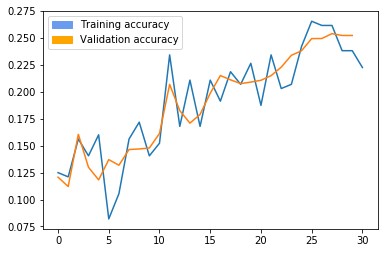

In [33]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['train_acc'], label='Training acc')
ax1.plot(info['valid_acc'], label='Validation acc')
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

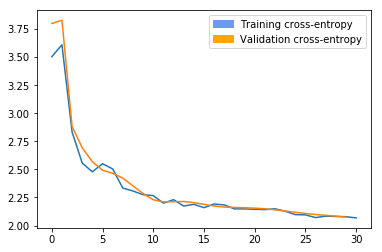

In [34]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['train_cost'], label='Training loss')
ax2.plot(info['valid_cost'], label='Validation loss')
blue_patch = mpatches.Patch(color='#699cef', label='Training cross-entropy')
orange_patch = mpatches.Patch(color='orange', label='Validation cross-entropy')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

#### Test accuracy

In [35]:
test_acc = session.run(accuracy, 
                       feed_dict={inputs: test_data_norm, targets: test_labels_ohe, keep_prob: 1.})
print("Test data accuracy: " + str(test_acc))

Test data accuracy: 0.2538


In [36]:
session.close()